In [1]:
import pandas as pd
from pyopenms import *

In [9]:

searchfile = "BSA1.mzML"
searchdb = "bsa.fasta"

# generate a protein database with additional decoy sequenes
targets = list()
decoys = list()
FASTAFile().load(searchdb, targets) # read FASTA file into a list of FASTAEntrys
decoy_generator = DecoyGenerator()
for entry in targets:
    rev_entry = FASTAEntry(entry) # copy entry
    rev_entry.identifier = "DECOY_" + rev_entry.identifier # mark as decoy
    aas = AASequence().fromString(rev_entry.sequence) # convert string into amino acid sequence
    rev_entry.sequence = decoy_generator.reverseProtein(aas).toString() # reverse
    decoys.append(rev_entry)




In [10]:
target_decoy_database = "search_td.fasta"
FASTAFile().store(target_decoy_database, targets + decoys) # store the database with appended decoy sequences

FASTAFile().store("decoy.fasta",  decoys) # store the database with appended decoy sequences

In [11]:
# Run SimpleSearchAlgorithm, store protein and peptide ids
protein_ids = []
peptide_ids = []

# set some custom search parameters
simplesearch = SimpleSearchEngineAlgorithm()
params = simplesearch.getDefaults()
score_annot = [b'fragment_mz_error_median_ppm', b'precursor_mz_error_ppm']
params.setValue(b'annotate:PSM', score_annot)
params.setValue(b'peptide:max_size', 30)
simplesearch.setParameters(params)

simplesearch.search(searchfile, target_decoy_database, protein_ids, peptide_ids)

In [12]:
sequence=list()
source=list()
score=list()
for peptide_id in peptide_ids:
      for hit in peptide_id.getHits():
            sequence.append(hit.getSequence())
            source.append(hit.getMetaValue("target_decoy"))
            score.append(hit.getScore())
data = {'Sequence':sequence,
      'Target_Decoy': source,
      'score':score
      }

df = pd.DataFrame(data)
df

,Sequence,Target_Decoy,score
0,DDSPDLPK,target,0.025953
1,YIC(Carbamidomethyl)DNQDTISSK,target,0.231189
2,C(Carbamidomethyl)C(Carbamidomethyl)TESLVNR,target,0.434824
3,LC(Carbamidomethyl)VLHEK,target,0.144144
4,FHEEGLDK,decoy,0.013783
5,DLGEEHFK,target,0.020626
6,LC(Carbamidomethyl)VLHEK,target,0.122978
7,LVTDLTK,target,0.016288
8,DLGEEHFK,target,1.432477
9,FHEEGLDK,decoy,0.008386


In [13]:
# Filter by 1% PSM FDR (q-value < 0.01)
idfilter = IDFilter()
idfilter.filterHitsByScore(peptide_ids, 0.01)

sequence=list()
source=list()
score=list()

for peptide_id in peptide_ids:
      for hit in peptide_id.getHits():
            sequence.append(hit.getSequence())
            source.append(hit.getMetaValue("target_decoy"))
            score.append(hit.getScore())
data = {'Sequence':sequence,
      'Target_Decoy': source,
      'score':score
      }

df = pd.DataFrame(data)
df


,Sequence,Target_Decoy,score
0,DDSPDLPK,target,0.025953
1,YIC(Carbamidomethyl)DNQDTISSK,target,0.231189
2,C(Carbamidomethyl)C(Carbamidomethyl)TESLVNR,target,0.434824
3,LC(Carbamidomethyl)VLHEK,target,0.144144
4,FHEEGLDK,decoy,0.013783
5,DLGEEHFK,target,0.020626
6,LC(Carbamidomethyl)VLHEK,target,0.122978
7,LVTDLTK,target,0.016288
8,DLGEEHFK,target,1.432477
9,AEFVEVTK,target,0.018760


In [14]:
idfilter.removeDecoyHits(peptide_ids)
sequence=list()
source=list()
score=list()

for peptide_id in peptide_ids:
      for hit in peptide_id.getHits():
            sequence.append(hit.getSequence())
            source.append(hit.getMetaValue("target_decoy"))
            score.append(hit.getScore())
data = {'Sequence':sequence,
      'Target_Decoy': source,
      'score':score
      }

df = pd.DataFrame(data)
df

,Sequence,Target_Decoy,score
0,DDSPDLPK,target,0.025953
1,YIC(Carbamidomethyl)DNQDTISSK,target,0.231189
2,C(Carbamidomethyl)C(Carbamidomethyl)TESLVNR,target,0.434824
3,LC(Carbamidomethyl)VLHEK,target,0.144144
4,DLGEEHFK,target,0.020626
5,LC(Carbamidomethyl)VLHEK,target,0.122978
6,LVTDLTK,target,0.016288
7,DLGEEHFK,target,1.432477
8,AEFVEVTK,target,0.018760
9,EAC(Carbamidomethyl)FAVEGPK,target,0.440584


In [15]:
from Bio import SeqIO
fasta_sequence = SeqIO.read(open("bsa.fasta"),'fasta')

In [16]:
exp = MSExperiment()
MzMLFile().load("BSA1.mzML", exp)

# Get first spectrum
spectra = exp.getSpectra()
observed_spectrum = spectra[0]

In [17]:
#  we generate the theoretical spectrum of that peptide:

tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)
peptide = AASequence.fromString(str(fasta_sequence.seq))
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

In [18]:
from matplotlib import pyplot as plt

def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
    theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 3.0)
    plt.bar(theo_mz, theo_int, width = 3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')

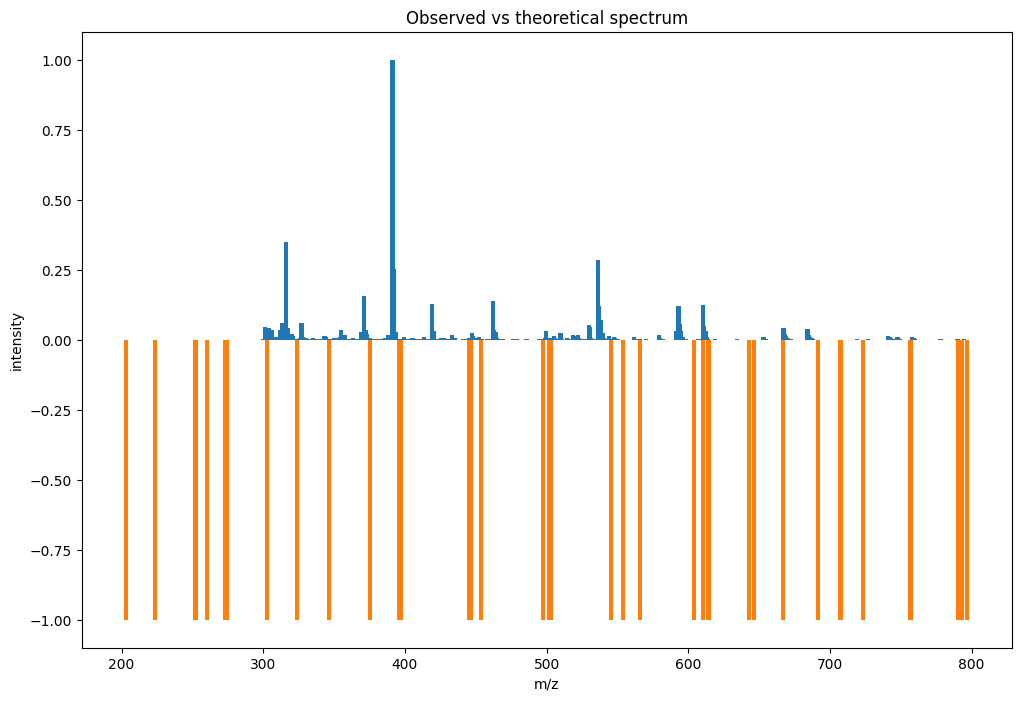

In [19]:
obs_mz, obs_int = observed_spectrum.get_peaks()
# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
   if mz >= 200.0 and mz <= 800.0:
      theo_mz.append(mz)
      theo_int.append(intensity)

title = 'Observed vs theoretical spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

In [20]:
# we want to find matching peaks between observed and theoretical spectrum

alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

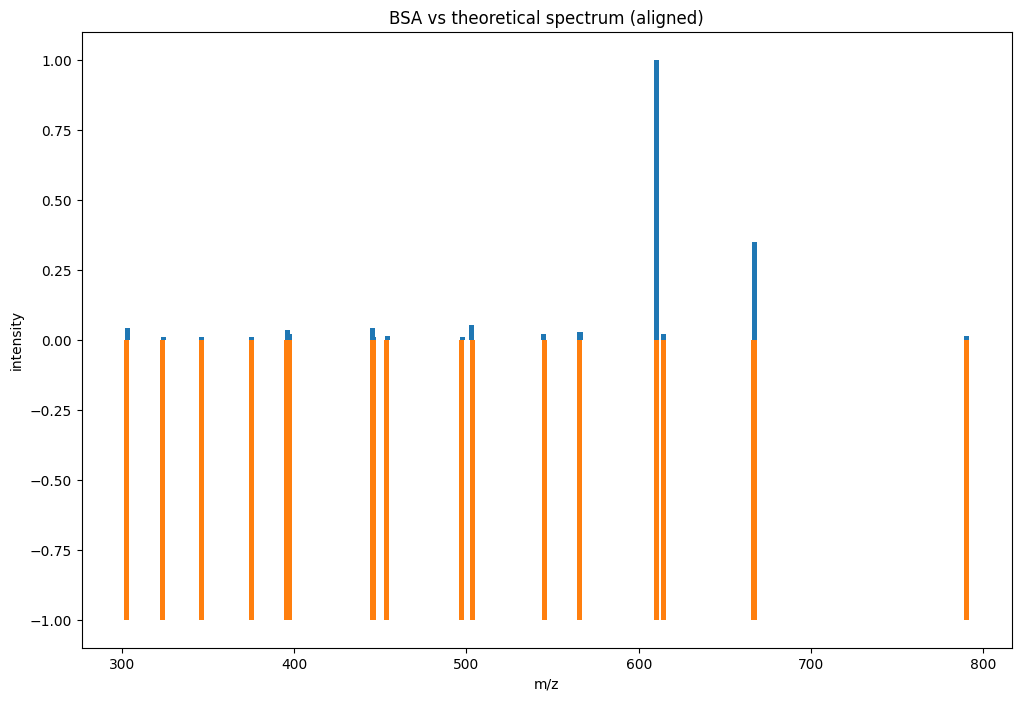

In [21]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'BSA vs theoretical spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)